## Deep Fake Detection Challenge

### Data Processing

##### Imports

In [88]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Tuple
from model2D import *
from model3D import *

##### Data Description

In [57]:
train_videoes = "data/train_sample_videos"
test_videos = "data/test_videos"

print(f"Train Videoes: {len(os.listdir(train_videoes))}\nTest Vidoes: {len(os.listdir(test_videos))}")

Train Videoes: 401
Test Vidoes: 400


In [58]:
meta_data = pd.read_json(train_videoes+"/metadata.json").T
meta_data.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [59]:
def visualize_real_vs_fake(class_count: list) -> None:
    plt.pie(class_count, labels=["Real Videos", "Deep Fake Videos"], autopct='%.2f%%',
       wedgeprops={'linewidth': 2.5, 'edgecolor': 'white'},
       textprops={'size': 'large', 'fontweight': 'bold'})
    plt.title("Proportion of Real vs Deep Fake videos in the training dataset.", fontdict={'fontweight': 'bold'})
    plt.legend([f"Real Videos Count: {class_count[0]}", f"Deep Fake Videos Count: {class_count[1]}"], bbox_to_anchor=(0.5, 0.05), bbox_transform=plt.gcf().transFigure, loc="lower center", prop={'weight':'bold'})
    plt.savefig("images/pie_chart_class_proportions.jpg")
    plt.show()

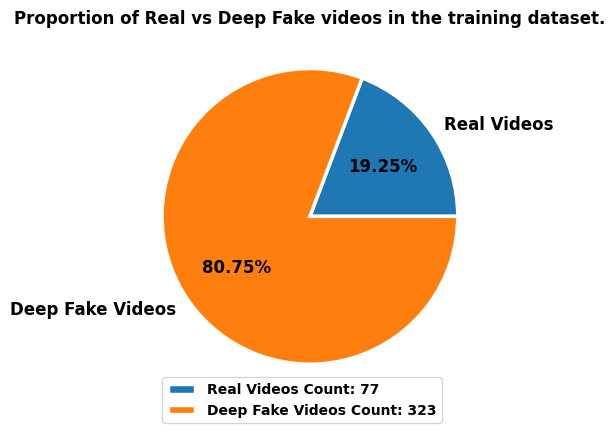

In [60]:
label_count_series = meta_data["label"].value_counts()
fake_count = label_count_series["FAKE"]
real_count = label_count_series["REAL"]

visualize_real_vs_fake([real_count, fake_count])

Quite skewed dataset. Might want to consider upsampling of real classes

In [78]:
def get_frames_v1(paths: list, frames_each_video: int, video_amount: int) -> list:
    video_array = []
    frames_to_skip = 300/frames_each_video
    for idx, path in enumerate(paths): # bedre me enumerate her?
        if idx == video_amount:
            break
        vc = cv2.VideoCapture(path)
        video = []
        i = 0
        while vc.isOpened():
            i += 1
            ret, frame = vc.read()
            if ret and frame is not None:
                if i % frames_to_skip != 0:
                    continue
                if frame.shape[0] == 1920:
                    frame = frame.transpose(1, 0, 2)
                frame = cv2.resize(frame, (1280, 720))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                if frame is None:
                    continue
                video.append(frame)
            else:
                vc.release()
                break
        video_array.append(np.array(video))
    return np.array(video_array)

training_videos_sample = os.listdir(train_videoes)
sample_file_names = training_videos_sample.copy()
complete_paths = []
for i in range(len(training_videos_sample)):
    if training_videos_sample[i].endswith('mp4'):
        complete_paths.append(train_videoes+"/"+training_videos_sample[i])
video_array = get_frames_v1(paths=complete_paths, frames_each_video=2, video_amount=10)

In [79]:
print(f"Amount of Videos: {len(video_array)}")
print(f"Frames for videos: {[len(video_array[i]) for i in range(len(video_array))]}")

Amount of Videos: 10
Frames for videos: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


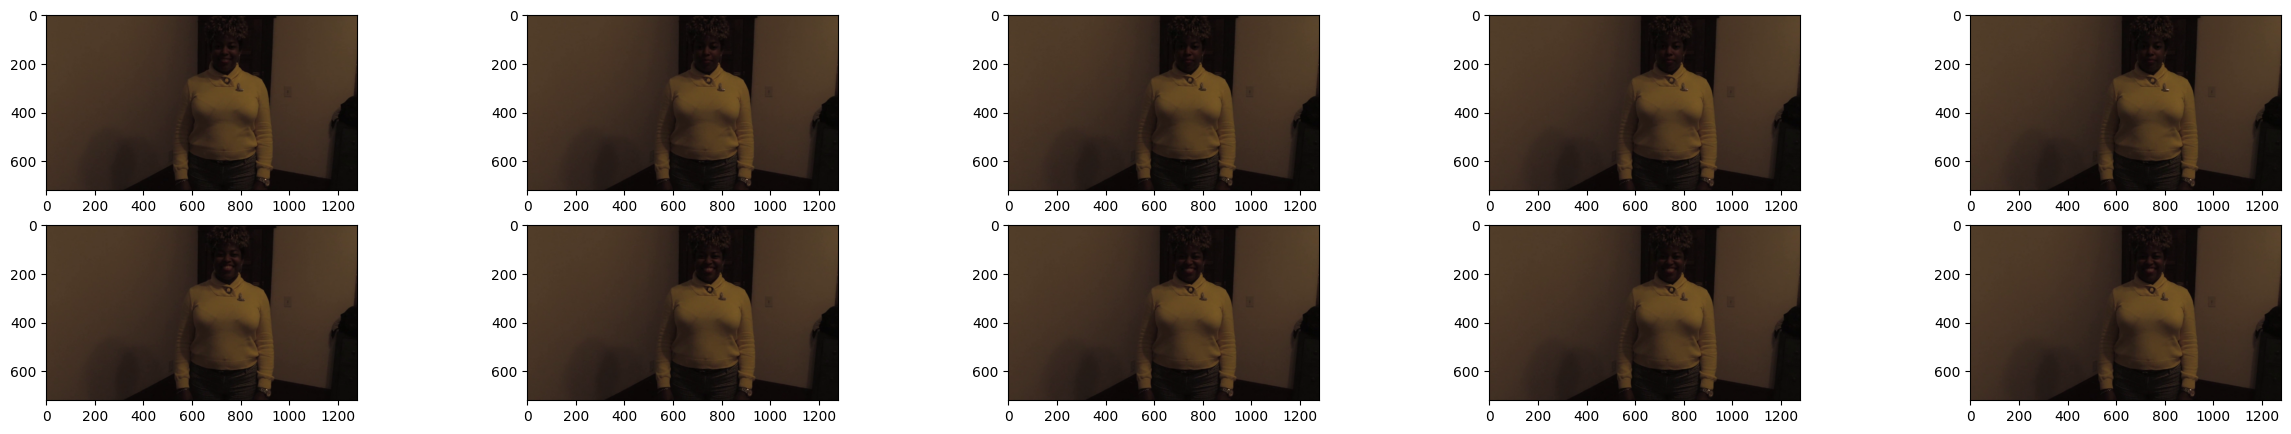

In [63]:
def plot_video(video: list, figsize: tuple, width: int, height: int) -> None:
    fig = plt.figure(figsize=figsize)
    for i in range(len(video[:(width*height)])):
        plt.subplot(width, height, i+1)
        plt.imshow(video[i])
    plt.show()

plot_video(video_array[6], (30,5), 2, 5)

In [64]:
from sklearn.manifold import TSNE
frames_list = video_array[0]
frames_array = np.array([frame.flatten() for frame in frames_list])
# Instantiate t-SNE object with desired parameters
print(2)
tsne = TSNE(n_components=2, perplexity=10, random_state=0)

# Fit t-SNE on the frames array
frames_tsne = tsne.fit_transform(frames_array)

2


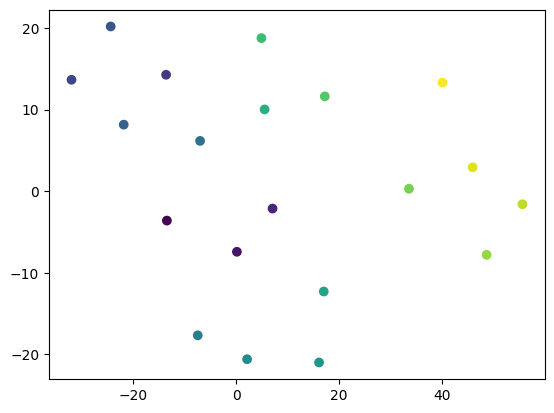

In [65]:
# Assuming labels is a list of labels corresponding to each frame
plt.scatter(frames_tsne[:,0], frames_tsne[:,1], c=range(0,20))
plt.show()

In [66]:
def format_frames(vid_arr):
    flatten_first_video_frame = vid_arr[0][0]
    flatten_first_video_frame = flatten_first_video_frame / 255
    return np.array([flatten_first_video_frame])
first_frame_formatted = format_frames(video_array)
first_frame_formatted.shape

(1, 720, 1280, 3)

### BUILD MODEL
- Add Layers
- Add Loss function, optimizers, and metrics
- Compile model and Fit

In [67]:
model_2D = build_2D_model(first_frame_formatted)
model_2D.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 720, 1280, 32)     4736      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 240, 426, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 240, 426, 3)       867       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 80, 142, 3)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 80, 142, 3)        84        
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 47, 3)       

In [68]:
model_2D = compile_2D_model(model_2D, 0.001)

In [80]:
video_array.shape

(10, 2, 720, 1280, 3)

In [89]:
model_3D = build_3D_model(video_array)
model_3D.summary()

ValueError: Exception encountered when calling layer "max_pooling3d_4" (type MaxPooling3D).

Negative dimension size caused by subtracting 3 from 2 for '{{node max_pooling3d_4/MaxPool3D}} = MaxPool3D[T=DT_FLOAT, data_format="NDHWC", ksize=[1, 3, 3, 3, 1], padding="VALID", strides=[1, 3, 3, 3, 1]](Placeholder)' with input shapes: [?,2,720,1280,32].

Call arguments received by layer "max_pooling3d_4" (type MaxPooling3D):
  • inputs=tf.Tensor(shape=(None, 2, 720, 1280, 32), dtype=float32)